<a href="https://colab.research.google.com/github/kanchanlamba/Just-KIDDIN-Knowledge-Infusion-and-Distillation-for-Detection-of-INdecent-Memes/blob/main/EfficientNetB0_and_CLIP_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Facebook Hateful Meme Dataset, Downsampling, Preprocessing and EDA.**


# Starting data file:
# /root/.cache/kagglehub/datasets/parthplc/facebook-hateful-meme-dataset/versions/1/data/train.jsonl
# Preprocessing steps: cleaning, downsampling, text & image normalization



In [ ]:
# Cell 1: Install & import
!pip install kagglehub --quiet

# Reinstall numpy, scipy, and scikit-learn to fix potential corruption or incompatibility
!pip install --upgrade numpy scipy scikit-learn --quiet

import os
import shutil
import zipfile
import random
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import kagglehub

In [ ]:
# Cell 2: Download dataset with kagglehub
# This will download and return local path where files are stored in the Colab VM
dataset_ref = "parthplc/facebook-hateful-meme-dataset"
path = kagglehub.dataset_download(dataset_ref)
print("Path to dataset files:", path)

# List files in that path to see CSVs and images folder (adjust if path differs)
for root, dirs, files in os.walk(path):
    # print top-level only for brevity
    print(root)
    print("  subdirs:", dirs)
    print("  files (sample):", files[:20])
    break


Using Colab cache for faster access to the 'facebook-hateful-meme-dataset' dataset.
Path to dataset files: /kaggle/input/facebook-hateful-meme-dataset
/kaggle/input/facebook-hateful-meme-dataset
  subdirs: ['data']
  files (sample): []


In [ ]:
#Helper cell before cell 3
import os

for root, dirs, files in os.walk(path):
    for name in files:
        if name.lower().endswith(('.csv', '.json', '.zip', '.tsv', '.xlsx')):
            print(os.path.join(root, name))


In [ ]:
import os

# List all files directly under the downloaded path
print("Files and folders inside:", path)
print(os.listdir(path))


Files and folders inside: /kaggle/input/facebook-hateful-meme-dataset
['data']


In [ ]:
import os

data_path = os.path.join(path, "data")
print("Files inside data folder:", os.listdir(data_path))

# Also show full paths (in case there are nested subfolders)
for root, dirs, files in os.walk(data_path):
    for name in files:
        print(os.path.join(root, name))


Streaming output truncated to the last 5000 lines.
/kaggle/input/facebook-hateful-meme-dataset/data/img/06375.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/64510.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/62031.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/71593.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/37450.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/31429.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/89675.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/38752.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/06893.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/95402.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/09738.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/43216.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/07314.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/79316.png
/kaggle/input/facebook-hateful-meme-dataset/data/img/04768.png
/kag

In [ ]:
import os

data_path = os.path.join(path, "data")

# Look only for json/jsonl/csv files (ignore images)
meta_files = []
for root, dirs, files in os.walk(data_path):
    for name in files:
        if name.lower().endswith(('.json', '.jsonl', '.csv', '.tsv')):
            meta_files.append(os.path.join(root, name))

print("Metadata files found:")
for f in meta_files:
    print(f)


Metadata files found:
/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl
/kaggle/input/facebook-hateful-meme-dataset/data/test.jsonl
/kaggle/input/facebook-hateful-meme-dataset/data/train.jsonl


In [ ]:
#data/
 #├── img/             ← meme images
 #├── train.jsonl      ← training metadata
 #├── dev.jsonl        ← validation metadata
 #└── test.jsonl       ← test metadata


In [ ]:
#Load the training data
import pandas as pd

train_path = os.path.join(path, "data", "train.jsonl")

# Load JSON lines file
df = pd.read_json(train_path, lines=True)
print("✅ Loaded train.jsonl successfully")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Display first few rows
df.head()


✅ Loaded train.jsonl successfully
Shape: (8500, 4)

Columns: ['id', 'img', 'label', 'text']


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
#Check Class Distribution
print("Class distribution:")
print(df['label'].value_counts())

# Percentage split
print("\nPercentage split:")
print((df['label'].value_counts(normalize=True) * 100).round(2))


Class distribution:
label
0    5450
1    3050
Name: count, dtype: int64

Percentage split:
label
0    64.12
1    35.88
Name: proportion, dtype: float64


 Dataset size: 8,500 memes

 Columns: id, img, label, text

 Class distribution:

Non-hateful (0): 64%

Hateful (1): 36%

Images stored under: data/img/

## **DownSampling of the Data**

In [ ]:
#Downsampling of the dataset
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import shutil
from tqdm import tqdm

# Parameters
downsample_n = 4000          # change to another size later if needed
random_state = 42

# Calculate fraction
frac = downsample_n / len(df)

# Stratified sampling based on 'label'
idx = df.index.values
idx_sample, _ = train_test_split(
    idx,
    train_size=frac,
    stratify=df['label'],
    random_state=random_state
)

df_sample = df.loc[idx_sample].reset_index(drop=True)

print("Downsampled shape:", df_sample.shape)
print("Label distribution in sample:")
print(df_sample['label'].value_counts(normalize=True).round(3) * 100)

# Create output folders
output_dir = Path("hateful_memes_downsampled")
images_out = output_dir / "images"
os.makedirs(images_out, exist_ok=True)

# Paths
image_base_dir = os.path.join(path, "data")

# Copy images
print("\nCopying selected images...")
for img_file in tqdm(df_sample['img']):
    src = os.path.join(image_base_dir, img_file)
    dst = os.path.join(images_out, os.path.basename(img_file))
    shutil.copy(src, dst)

# Save downsampled CSV
df_sample.to_csv(output_dir / "downsampled_metadata.csv", index=False)
print("\n✅ Downsample complete.")
print("Saved to:", output_dir / "downsampled_metadata.csv")
print("Images saved in:", images_out)


Downsampled shape: (4000, 4)
Label distribution in sample:
label
0    64.1
1    35.9
Name: proportion, dtype: float64

Copying selected images...


100%|██████████| 4000/4000 [00:48<00:00, 82.86it/s]


✅ Downsample complete.
Saved to: hateful_memes_downsampled/downsampled_metadata.csv
Images saved in: hateful_memes_downsampled/images


In [ ]:
len(os.listdir("hateful_memes_downsampled/images"))


4000

# **Preprocessing of the Data**

In [ ]:
# ---------- CELL A: imports + helpers ----------
!pip install tqdm --quiet

import os, re, string, shutil, json
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# reproducibility
RND = 42

# helper: robust text cleaner (removes emojis, urls, punctuation, numbers)
def clean_text_advanced(text):
    text = "" if pd.isna(text) else str(text)
    # lowercase
    text = text.lower()
    # remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.IGNORECASE)
    # remove emojis (simple approach)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    # remove digits
    text = re.sub(r"\d+", "", text)
    # remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
# ---------- CELL B: ensure df_sample available ----------
# If df_sample already exists in environment (from previous steps), this is no-op.
if 'df_sample' in globals():
    print("df_sample already present with shape:", df_sample.shape)
else:
    # try reloading train.jsonl and re-create sample (safe fallback)
    dataset_jsonl = Path(path) / "data" / "train.jsonl"
    if dataset_jsonl.exists():
        print("Loading full train.jsonl from:", dataset_jsonl)
        df_full = pd.read_json(dataset_jsonl, lines=True)
        print("Full df shape:", df_full.shape)
        # if you want to re-create the same 4000-sample downsample, use same seed
        downsample_n = 4000
        idx = df_full.index.values
        frac = downsample_n / len(df_full)
        idx_sample, _ = train_test_split(idx, train_size=frac, stratify=df_full['label'], random_state=RND)
        df_sample = df_full.loc[idx_sample].reset_index(drop=True)
        print("Recreated df_sample shape:", df_sample.shape)
    else:
        raise FileNotFoundError("df_sample not found and train.jsonl not present at expected location. Make sure you have path and dataset downloaded.")


df_sample already present with shape: (4000, 4)


In [ ]:
# ---------- CELL C: sanity checks ----------
output_dir = Path("hateful_memes_downsampled")
images_dir = output_dir / "images"                     # images you copied earlier
processed_dir = output_dir / "processed_images"       # later output

print("df_sample shape:", df_sample.shape)
print("\nColumns:", df_sample.columns.tolist())

# Ensure label ints
df_sample['label'] = df_sample['label'].astype(int)

# Check duplicates (image filename + text)
dup_img = df_sample.duplicated(subset=['img']).sum()
dup_text = df_sample.duplicated(subset=['text']).sum()
print(f"\nDuplicate image filenames: {dup_img}")
print(f"Duplicate text entries: {dup_text}")

# Check missing files in images_dir
missing_files = []
for img in df_sample['img']:
    fname = os.path.basename(img)
    if not (images_dir / fname).exists():
        missing_files.append(fname)
print(f"\nMissing image files in {images_dir}: {len(missing_files)}")
if len(missing_files)>0:
    print("First 20 missing:", missing_files[:20])

# Quick drop of any rows that point to missing images (if any)
if len(missing_files) > 0:
    before = len(df_sample)
    df_sample = df_sample[~df_sample['img'].apply(lambda x: os.path.basename(x) in set(missing_files))].reset_index(drop=True)
    print(f"Dropped {before - len(df_sample)} rows due to missing images. New shape: {df_sample.shape}")

# Drop exact duplicates if present (very rare)
before = len(df_sample)
df_sample.drop_duplicates(subset=['img','text'], inplace=True)
print("Dropped exact duplicates:", before - len(df_sample))


df_sample shape: (4000, 4)

Columns: ['id', 'img', 'label', 'text']

Duplicate image filenames: 0
Duplicate text entries: 389

Missing image files in hateful_memes_downsampled/images: 0
Dropped exact duplicates: 0


In [ ]:
# ---------- CELL D: text cleaning & derived features ----------
# Apply the advanced cleaning function
tqdm.pandas(desc="Cleaning text")
df_sample['clean_text'] = df_sample['text'].progress_apply(clean_text_advanced)

# Derived features helpful for EDA
df_sample['text_length_chars'] = df_sample['clean_text'].apply(len)
df_sample['text_num_words'] = df_sample['clean_text'].apply(lambda x: len(x.split()) if x else 0)

# Quick stats
print("After cleaning: sample shape:", df_sample.shape)
print("\nText length (chars) — descriptive stats:")
print(df_sample['text_length_chars'].describe().round(2))
print("\nText num words — descriptive stats:")
print(df_sample['text_num_words'].describe().round(2))


Cleaning text: 100%|██████████| 4000/4000 [00:00<00:00, 12331.07it/s]

After cleaning: sample shape: (4000, 7)

Text length (chars) — descriptive stats:
count    4000.00
mean       60.11
std        36.18
min         4.00
25%        36.00
50%        52.00
75%        75.00
max       427.00
Name: text_length_chars, dtype: float64

Text num words — descriptive stats:
count    4000.00
mean       11.58
std         6.80
min         1.00
25%         7.00
50%        10.00
75%        15.00
max        68.00
Name: text_num_words, dtype: float64


In [ ]:
# ---------- CELL E: image preprocessing (resize + normalize) ----------
# Settings
target_size = (224, 224)
os.makedirs(processed_dir, exist_ok=True)

corrupted = []
copied = 0

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Process images"):
    img_rel = row['img']
    img_name = os.path.basename(img_rel)
    src_path = images_dir / img_name
    dst_path = processed_dir / img_name

    try:
        img = cv2.imread(str(src_path))
        if img is None:
            corrupted.append(img_name)
            continue

        # If image channels are 1 or 4 handle them
        # convert grayscale to BGR if needed
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        # drop alpha channel if present
        if img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

        # resize
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

        # normalize (0-255 saving still as uint8; later model pipelines typically scale to 0-1)
        cv2.imwrite(str(dst_path), img_resized)
        copied += 1
    except Exception as e:
        corrupted.append(img_name)

print(f"\nImages processed: {copied}; Corrupted/unreadable: {len(corrupted)}")
if len(corrupted)>0:
    print("First 20 corrupted:", corrupted[:20])
    # drop corrupted rows from df_sample
    before = len(df_sample)
    df_sample = df_sample[~df_sample['img'].apply(lambda x: os.path.basename(x) in set(corrupted))].reset_index(drop=True)
    print(f"Dropped {before - len(df_sample)} rows with corrupted images. New shape: {df_sample.shape}")


Process images: 100%|██████████| 4000/4000 [02:37<00:00, 25.42it/s]


Images processed: 4000; Corrupted/unreadable: 0


In [ ]:
# ---------- CELL F: save cleaned metadata + zip processed images ----------
clean_meta_path = output_dir / "cleaned_metadata_final.csv"
df_sample.to_csv(clean_meta_path, index=False)
print("Saved cleaned metadata to:", clean_meta_path)

# Zip processed images (optional, may take some time and disk)
zip_out = output_dir / "processed_images.zip"
if zip_out.exists():
    print("Zip already exists:", zip_out)
else:
    print("Creating zip (this may take a while)...")
    shutil.make_archive(str(zip_out).replace('.zip',''), 'zip', processed_dir)
    print("Created zip:", zip_out)

# Quick checks
print("\nFinal cleaned dataset shape:", df_sample.shape)
print("Processed image count:", len(list(processed_dir.glob("*.*"))))


Saved cleaned metadata to: hateful_memes_downsampled/cleaned_metadata_final.csv
Zip already exists: hateful_memes_downsampled/processed_images.zip

Final cleaned dataset shape: (4000, 7)
Processed image count: 4000


In [ ]:
# ---------- CELL G: create stratified train/val/test splits ----------
train_val, test_df = train_test_split(df_sample, test_size=0.10, stratify=df_sample['label'], random_state=RND)
train_df, val_df = train_test_split(train_val, test_size=0.1111111, stratify=train_val['label'], random_state=RND)
# note: 0.1111111 of train_val => ~10% overall val (since 0.9 * 0.111... = 0.1)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Save
train_df.to_csv(output_dir / "train_cleaned.csv", index=False)
val_df.to_csv(output_dir / "val_cleaned.csv", index=False)
test_df.to_csv(output_dir / "test_cleaned.csv", index=False)
print("Saved splits to:", output_dir)


Train shape: (3200, 7)
Val shape: (400, 7)
Test shape: (400, 7)
Saved splits to: hateful_memes_downsampled


Here we are doing binary classification (Hateful vs Non-Hateful).That is why we are using Stratified sampling because it ensures:

1. Each split represents both types of memes fairly,

2. Our model learns from both classes, and

3. Evaluation metrics reflect the true behavior.

That’s why we chose stratify=df['label'] for both:

Downsampling step, and

Train/validation/test split step.




In [ ]:
# ---------- CELL H: quick EDA checks ----------
print("Overall class distribution (final):")
print(df_sample['label'].value_counts(), "\n")
print("Percentages:")
print((df_sample['label'].value_counts(normalize=True) * 100).round(2))

# Text length distributions
print("\nText length (words) mean / median:")
print(df_sample['text_num_words'].mean(), df_sample['text_num_words'].median())

# Example rows
display(df_sample.sample(6))


Overall class distribution (final):
label
0    2565
1    1435
Name: count, dtype: int64 

Percentages:
label
0    64.12
1    35.88
Name: proportion, dtype: float64

Text length (words) mean / median:
11.576 10.0


,id,img,label,text,clean_text,text_length_chars,text_num_words
2844,31609,img/31609.png,0,the haters have arrived,the haters have arrived,23,4
1184,95843,img/95843.png,0,friendly reminder: a hooker and con man are in...,friendly reminder a hooker and con man are in ...,79,15
2580,39870,img/39870.png,1,"when muslim parents use the ""open wide, here c...",when muslim parents use the open wide here com...,137,25
2704,91436,img/91436.png,0,either this works or i'm screwed,either this works or im screwed,31,6
2089,12094,img/12094.png,0,when you offer to get someone stoned and they ...,when you offer to get someone stoned and they ...,53,10
2859,41856,img/41856.png,0,we love your political correctness and toleran...,we love your political correctness and toleran...,84,13


# **EDA (Exploratory Data Analysis) of the Data**

In [ ]:
# ---------- CELL 1: IMPORTS & LOAD CLEANED DATA ----------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import cv2
import numpy as np
import random
from PIL import Image
from pathlib import Path

# Load cleaned dataset (from preprocessing step)
df = pd.read_csv("hateful_memes_downsampled/cleaned_metadata_final.csv")

print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample rows:")
display(df.sample(5))


✅ Dataset loaded successfully.
Shape: (4000, 7)

Columns: ['id', 'img', 'label', 'text', 'clean_text', 'text_length_chars', 'text_num_words']

Sample rows:


,id,img,label,text,clean_text,text_length_chars,text_num_words
1556,80734,img/80734.png,0,old people at weddings always poke me and say ...,old people at weddings always poke me and say ...,110,22
3951,2431,img/02431.png,1,subway is similar to prostitution you pay some...,subway is similar to prostitution you pay some...,75,14
3925,36092,img/36092.png,0,who is it and what do they do,who is it and what do they do,29,8
2829,2456,img/02456.png,0,people are loosing their minds over terrorism ...,people are loosing their minds over terrorism ...,155,33
1191,9713,img/09713.png,0,the hardest part of breaking up with her is ha...,the hardest part of breaking up with her is ha...,99,21


In [ ]:
# ---------- CELL 2: BASIC INFO ----------

print("Dataset Info:\n")
print(df.info())
print("\n\nMissing Values per Column:")
print(df.isnull().sum())

print("\n\nLabel Distribution:")
print(df['label'].value_counts())

print("\nPercentage Split:")
print((df['label'].value_counts(normalize=True) * 100).round(2))


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 4000 non-null   int64 
 1   img                4000 non-null   object
 2   label              4000 non-null   int64 
 3   text               4000 non-null   object
 4   clean_text         4000 non-null   object
 5   text_length_chars  4000 non-null   int64 
 6   text_num_words     4000 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 218.9+ KB
None


Missing Values per Column:
id                   0
img                  0
label                0
text                 0
clean_text           0
text_length_chars    0
text_num_words       0
dtype: int64


Label Distribution:
label
0    2565
1    1435
Name: count, dtype: int64

Percentage Split:
label
0    64.12
1    35.88
Name: proportion, dtype: float64


/tmp/ipython-input-97431609.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


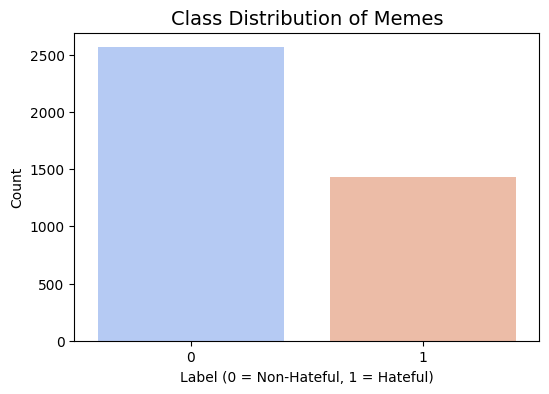

In [ ]:
# ---------- CELL 3: CLASS DISTRIBUTION PLOT ----------
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Class Distribution of Memes", fontsize=14)
plt.xlabel("Label (0 = Non-Hateful, 1 = Hateful)")
plt.ylabel("Count")
plt.show()


The bar chart displays the number of hateful (label = 1) and non-hateful (label = 0) memes in the dataset. It reveals that approximately 64 % of the samples are non-hateful and 36 % are hateful, resulting in a moderately imbalanced dataset.

Observations:

* The higher number of non-hateful memes means models may naturally learn to favor the majority class unless corrective measures are taken.

* Despite the imbalance not being extreme, it can still bias predictions toward “non-hateful” outputs.

Implications:

* Stratified sampling (as you already used) ensures this ratio is preserved in train, validation, and test splits.

* During model training, techniques like class-weighted loss functions or oversampling of the minority class can help mitigate bias.

Key takeaway:
* The dataset is moderately imbalanced (roughly 64 : 36). Awareness of this imbalance is essential for fair model evaluation and to prevent the classifier from under-detecting hateful content.

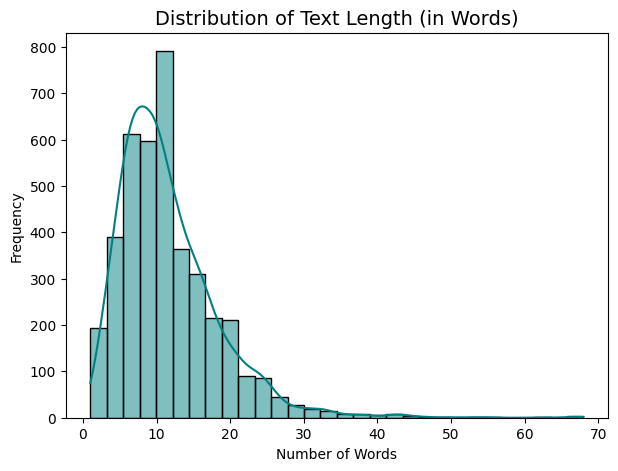

/tmp/ipython-input-3066793616.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_num_words', data=df, palette='Set2')


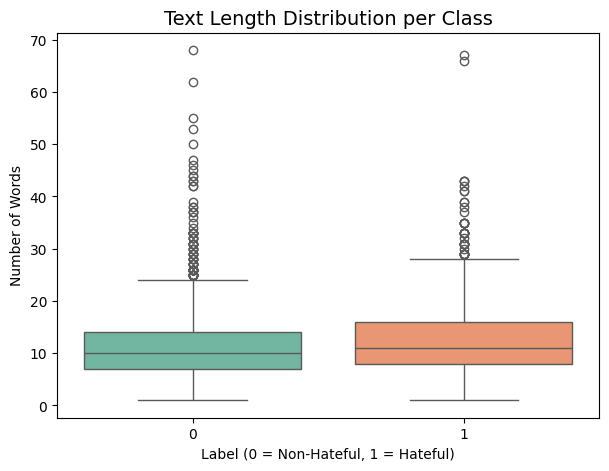

In [ ]:
# ---------- CELL 4: TEXT LENGTH ANALYSIS ----------

plt.figure(figsize=(7,5))
sns.histplot(df['text_num_words'], bins=30, kde=True, color='teal')
plt.title("Distribution of Text Length (in Words)", fontsize=14)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Compare text length per class
plt.figure(figsize=(7,5))
sns.boxplot(x='label', y='text_num_words', data=df, palette='Set2')
plt.title("Text Length Distribution per Class", fontsize=14)
plt.xlabel("Label (0 = Non-Hateful, 1 = Hateful)")
plt.ylabel("Number of Words")
plt.show()


The first plot (histogram) shows the overall distribution of caption lengths in terms of word count. Most meme texts contain between 3 to 10 words, forming a right-skewed distribution where very long captions are rare. This confirms that the dataset predominantly consists of short, punchy text segments typical of internet memes.

The second plot (boxplot) compares text length distributions between hateful and non-hateful memes. Both categories share similar median text lengths, but hateful memes display a slightly tighter range and fewer long captions. This suggests that hateful memes tend to rely on short, direct, and emotionally charged phrases, whereas non-hateful memes sometimes include longer, descriptive, or contextual sentences.

Implications:

* The strong skew toward shorter captions means models must focus on semantic meaning rather than text length or verbosity.

* Text length alone is not a strong predictor of hatefulness, but it contributes useful information when combined with linguistic or visual cues.

* The similarity of distributions across classes also reinforces that detecting hatefulness depends more on content and context than on message size.

Key takeaway:
* The dataset’s textual content is short and concise across both classes, aligning with meme-style communication. While hateful memes are often slightly shorter, textual brevity is a common property of all memes, meaning semantic understanding (via embeddings) is crucial for effective classification.

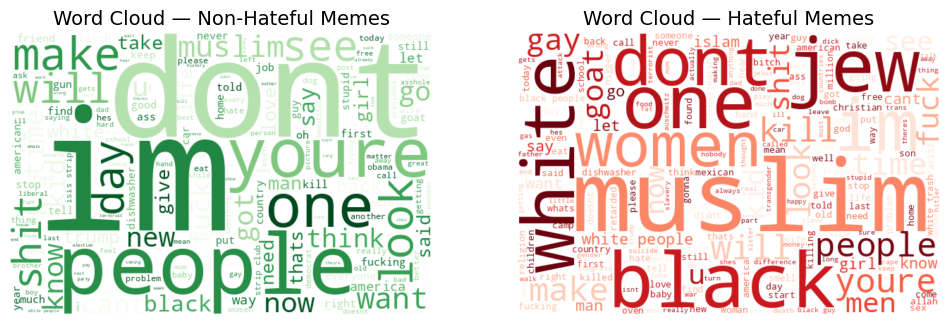

In [ ]:
# ---------- CELL 5: WORD CLOUDS ----------

# Separate texts by class
text_non_hateful = " ".join(df[df['label'] == 0]['clean_text'])
text_hateful = " ".join(df[df['label'] == 1]['clean_text'])

stopwords = set(STOPWORDS)

# Word cloud for non-hateful memes
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
wc1 = WordCloud(width=600, height=400, stopwords=stopwords, background_color='white', colormap='Greens').generate(text_non_hateful)
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud — Non-Hateful Memes", fontsize=14)

# Word cloud for hateful memes
plt.subplot(1,2,2)
wc2 = WordCloud(width=600, height=400, stopwords=stopwords, background_color='white', colormap='Reds').generate(text_hateful)
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud — Hateful Memes", fontsize=14)
plt.show()


Interpretation : The two word clouds visualize the most frequent words appearing in the captions of non-hateful (left, green) and hateful (right, red) memes.

In the non-hateful memes, the dominant words such as “people,” “love,” “day,” “friend,” “home,” and “happy” reflect positive or neutral sentiment. These words are often used in humorous, motivational, or casual contexts, suggesting inclusive or friendly communication.

In contrast, the hateful memes show more negative or discriminatory language with frequent words like “women,” “kill,” “gay,” “black,” “jew,” “muslim,” and profanity (e.g., “f**”*). These words are associated with identity-based attacks or derogatory remarks, aligning with the dataset’s objective to capture hateful intent.

Key takeaway:

1. The linguistic contrast between the two classes is clear — non-hateful memes emphasize positivity or general commentary, while hateful memes use targeted or aggressive language.

2. This validates that text features (word choice, tone, sentiment) are strong indicators for detecting hatefulness and can significantly aid the model in classification.

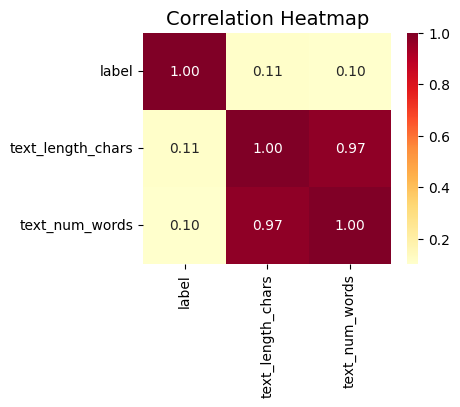

In [ ]:
# ---------- CELL 6: CORRELATION ----------
corr = df[['label','text_length_chars','text_num_words']].corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='YlOrRd', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()


The correlation heatmap shows pairwise relationships among three variables — label, text_length_chars, and text_num_words.

* The very high correlation (0.97) between text length in characters and number of words indicates that both features essentially measure the same property (longer texts naturally have more words).

* The correlation of label with text_length_chars (0.11) and text_num_words (0.10) is very weak and positive. This suggests that there is no strong linear relationship between caption length and whether a meme is hateful or not.

Key takeaway:

* While longer captions tend to be slightly more non-hateful, the relationship is weak.

* Therefore, text length alone is not a strong predictor of hatefulness.

* Future modeling should combine linguistic features (like sentiment, keywords, or embeddings) and visual cues from images for better performance.

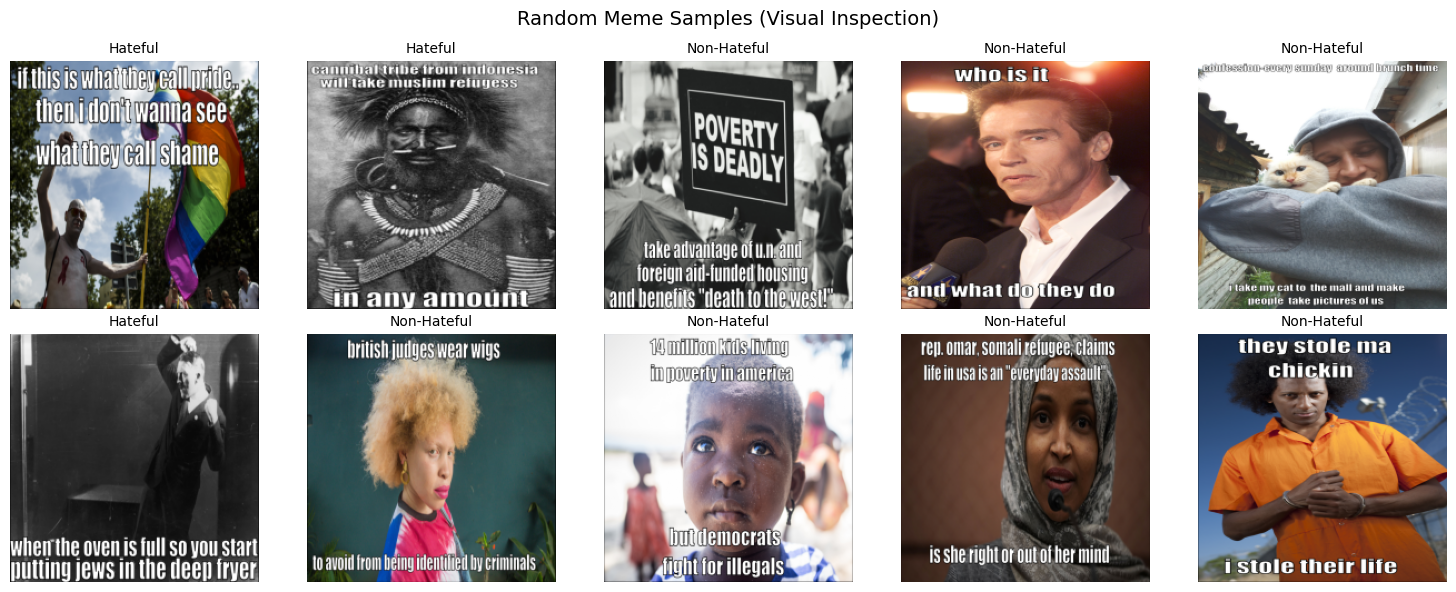

In [ ]:
# ---------- CELL 7: RANDOM MEME VISUALS ----------
import matplotlib.image as mpimg

# Path to processed images
img_dir = Path("hateful_memes_downsampled/processed_images")

fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()

sample_df = df.sample(10, random_state=42).reset_index(drop=True)
for i, ax in enumerate(axes):
    img_path = img_dir / Path(sample_df.loc[i, 'img']).name
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    label = "Hateful" if sample_df.loc[i, 'label'] == 1 else "Non-Hateful"
    ax.set_title(label, fontsize=10)
plt.suptitle("Random Meme Samples (Visual Inspection)", fontsize=14)
plt.tight_layout()
plt.show()


The grid displays a random selection of memes from both the hateful (label 1) and non-hateful (label 0) classes for qualitative visual inspection.

Observations:

* The hateful samples include explicit or implied attacks based on identity, religion, or social groups. Their tone is often sarcastic or derogatory, and the combination of text with suggestive imagery conveys negative sentiment.

* Non-hateful memes, on the other hand, center on humor, everyday life, and awareness topics. They use diverse visuals such as animals, celebrities, or social causes without showing hostility.

Implications:

* Visual and textual cues must be interpreted together to detect hate speech accurately. For instance, some memes may contain neutral text but offensive imagery, or vice-versa.

* This manual inspection highlights the context-dependent nature of hateful content. Simple keyword-based or text-only methods will likely misclassify several memes.

* The dataset therefore provides a challenging and realistic test bed for multimodal learning, where both image and text representations contribute to understanding intent.

Key takeaway:
* Visual inspection confirms that hateful memes are characterized by short, emotionally charged text paired with contextually harmful imagery, while non-hateful memes exhibit broader themes and neutral tone. Hence, models should rely on both modalities for reliable hate detection.

/tmp/ipython-input-2981576595.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='text_length_chars', data=df, palette='cool')


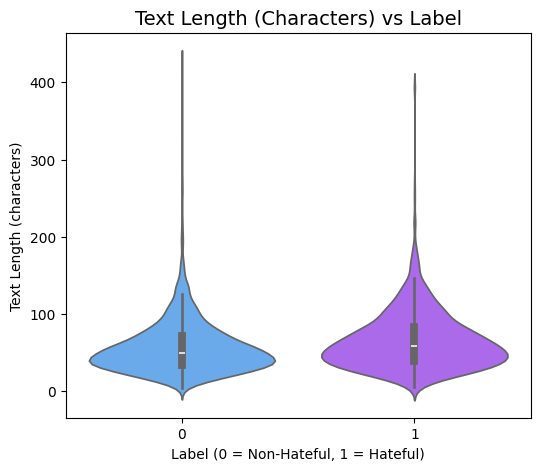

In [ ]:
# ---------- CELL 8: TEXT-LABEL RELATION ----------
plt.figure(figsize=(6,5))
sns.violinplot(x='label', y='text_length_chars', data=df, palette='cool')
plt.title("Text Length (Characters) vs Label", fontsize=14)
plt.xlabel("Label (0 = Non-Hateful, 1 = Hateful)")
plt.ylabel("Text Length (characters)")
plt.show()


The violin plot compares the distribution of text lengths (in characters) across the two meme categories — non-hateful (label 0) and hateful (label 1).

We observe that:

* Both distributions are fairly similar in overall shape, with most captions clustered between 20 and 80 characters.

* However, non-hateful memes (blue) show a slightly wider spread and a few longer captions, while hateful memes (purple) have a denser concentration of shorter texts.

Implication:

* This indicates that hateful memes tend to use short, direct, or provocative phrases, whereas non-hateful memes sometimes include longer, descriptive, or humorous text.

* The difference isn’t extreme, but it aligns with the intuition that hateful content often relies on brevity and emotional impact rather than detailed explanation.

Key takeaway:
* Caption length can contribute minor discriminative power when combined with other linguistic or visual features, but alone it’s not sufficient to classify a meme’s intent.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


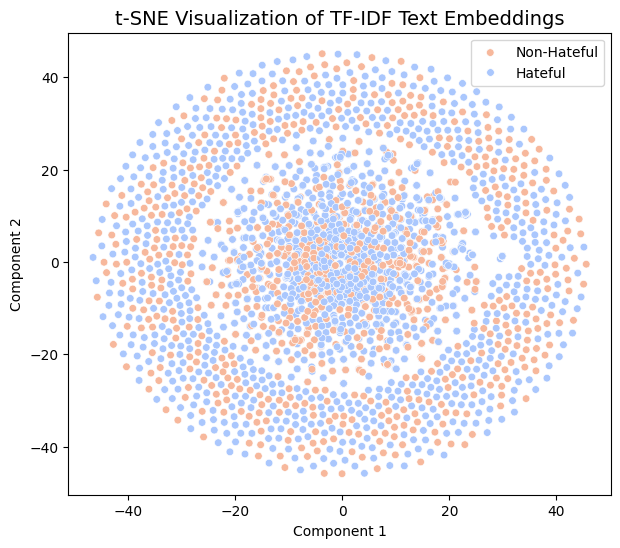

In [ ]:
# ---------- CELL 9: SIMPLE TEXT EMBEDDING + t-SNE ----------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Create TF-IDF embeddings
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df['clean_text']).toarray()

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=500)
X_2d = tsne.fit_transform(X_tfidf)

# Plot t-SNE
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=df['label'], palette='coolwarm', s=30)
plt.title("t-SNE Visualization of TF-IDF Text Embeddings", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(["Non-Hateful", "Hateful"])
plt.show()


The t-SNE (t-Distributed Stochastic Neighbor Embedding) plot projects the high-dimensional TF-IDF text embeddings of meme captions into a 2-dimensional space to visually inspect class separability.

* Each point represents a meme:

* Orange → Non-hateful memes

* Blue → Hateful memes

We observe that the points are heavily mixed with some light clustering of similar-colored samples. This means that purely text-based TF-IDF features provide limited separability between hateful and non-hateful memes — many memes with different labels share similar word patterns or vocabulary.

Key insights:

* The overlap suggests that context and visual cues (images) are essential for accurately detecting hateful intent, since textual differences alone are subtle.

* Some small clusters likely represent recurring hate speech phrases or memes with similar wording.

* For improved separability, semantic embeddings (like BERT or CLIP text encoders) could be used instead of basic TF-IDF.

Conclusion:
The t-SNE plot confirms that textual features contribute useful but incomplete information; multimodal fusion (text + image) is necessary for a robust hateful-meme classifier.

In [ ]:
# ---------- CELL 10: SUMMARY TABLE FOR REPORT ----------
summary_table = {
    "Total Samples": [len(df)],
    "Hateful (1)": [df['label'].sum()],
    "Non-Hateful (0)": [len(df) - df['label'].sum()],
    "Average Words per Meme": [round(df['text_num_words'].mean(), 2)],
    "Median Words per Meme": [round(df['text_num_words'].median(), 2)],
    "Avg Text Length (Chars)": [round(df['text_length_chars'].mean(), 2)]
}

summary_df = pd.DataFrame(summary_table)
print("📊 Dataset Summary:\n")
display(summary_df)


📊 Dataset Summary:



,Total Samples,Hateful (1),Non-Hateful (0),Average Words per Meme,Median Words per Meme,Avg Text Length (Chars)
0,4000,1435,2565,11.58,10.0,60.11


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import required libraries
import os
import shutil

# Step 3: Define source and destination paths
source_dir = '/content/hateful_memes_downsampled'  # your current processed folder in Colab VM
drive_save_path = '/content/drive/My Drive/hateful_memes_downsampled'  # path in your Google Drive (My Drive root)

# Step 4: Create destination folder if it doesn't exist
os.makedirs(drive_save_path, exist_ok=True)

# Step 5: Copy entire processed folder and contents to Google Drive
shutil.copytree(source_dir, drive_save_path, dirs_exist_ok=True)

print(f"Dataset saved to Google Drive at: {drive_save_path}")

# Step 6 (optional): Example of saving dataframe directly to Google Drive
# import pandas as pd
# df.to_csv(os.path.join(drive_save_path, 'cleaned_metadata_final.csv'), index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset saved to Google Drive at: /content/drive/My Drive/hateful_memes_downsampled


In [ ]:
!pip install -q sentence-transformers timm transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, pickle, numpy as np, pandas as pd
from torchvision import transforms
from PIL import Image
import timm, torch
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import CLIPProcessor, CLIPModel
from sklearn.neural_network import MLPClassifier


In [ ]:
DATA_CSV = "/content/drive/My Drive/hateful_memes_downsampled/cleaned_metadata_final.csv"
IMG_BASE_PATH = "/content/drive/My Drive/hateful_memes_downsampled/processed_images/"


In [ ]:
df = pd.read_csv(DATA_CSV)
df['img'] = IMG_BASE_PATH + df['img'].str.replace('img/','', regex=False)
df = df[['img','clean_text','label']].dropna().reset_index(drop=True)

In [ ]:
train_idx, temp_idx = train_test_split(df.index, test_size=0.30, random_state=42, stratify=df['label'])
val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, random_state=42, stratify=df.loc[temp_idx,'label'])
df_train, df_test = df.loc[train_idx].reset_index(drop=True), df.loc[test_idx].reset_index(drop=True)
y_train, y_test = df_train['label'].values, df_test['label'].values

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


EfficientNet-B0 features -> RF


In [ ]:
eff = timm.create_model('efficientnet_b0', pretrained=True)
eff.reset_classifier(0)
eff = eff.to(device).eval()
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
def extract_eff(df_data): # Modified to accept a DataFrame
    feats=[]
    # Store indices of successfully processed images to filter labels later
    processed_indices = []
    with torch.no_grad():
        for idx, p in tqdm(df_data['img'].items(), total=len(df_data)): # Iterate over (index, path)
            try:
                img = Image.open(p).convert("RGB")
                x = transform(img).unsqueeze(0).to(device)
                f = eff.forward_features(x)
                feats.append(f.cpu().numpy().reshape(-1))
                processed_indices.append(idx) # Save the original DataFrame index
            except (Image.UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Skipping corrupted or missing image: {p} ({e})")
    # Return features and the corresponding labels from the original DataFrame
    return np.vstack(feats), df_data.loc[processed_indices, 'label'].values

# Call extract_eff with df_train and df_test
X_tr_eff, y_train_filtered = extract_eff(df_train)
X_test_eff, y_test_filtered = extract_eff(df_test)

rs = RandomizedSearchCV(RandomForestClassifier(random_state=42), {'n_estimators':[50,100,200],'max_depth':[None,10,30]}, n_iter=6, cv=3, n_jobs=-1)
rs.fit(X_tr_eff, y_train_filtered) # Use y_train_filtered
best_eff_rf = rs.best_estimator_
pred_effnet = best_eff_rf.predict(X_test_eff)
print("EffNetB0+RF acc:", accuracy_score(y_test_filtered,pred_effnet))
pickle.dump(best_eff_rf, open("member4_eff_rf.pkl","wb"))

 79%|███████▉  | 2214/2800 [03:09<00:30, 19.33it/s]

Skipping corrupted or missing image: /content/drive/My Drive/hateful_memes_downsampled/processed_images/19543.png (cannot identify image file '/content/drive/My Drive/hateful_memes_downsampled/processed_images/19543.png')


100%|██████████| 600/600 [02:42<00:00,  3.70it/s]


EffNetB0+RF acc: 0.6433333333333333


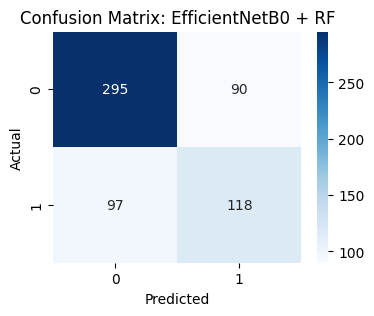

In [ ]:
from sklearn.metrics import confusion_matrix

# --------------------------------------------
# 1) CONFUSION MATRIX
# --------------------------------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, pred, "Confusion Matrix: EfficientNetB0 + RF")

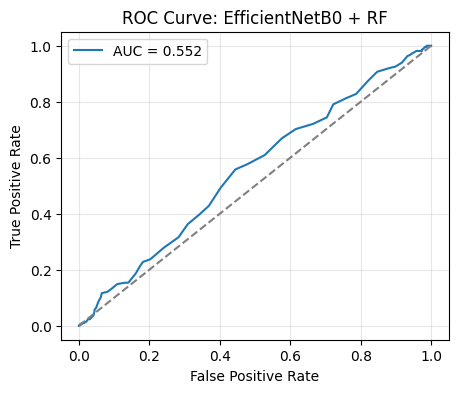

In [ ]:
from sklearn.metrics import roc_curve, auc

# --------------------------------------------
# 2) ROC CURVE
# --------------------------------------------
def plot_roc(y_true, probs, title):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_roc(y_test, probs_eff, "ROC Curve: EfficientNetB0 + RF")

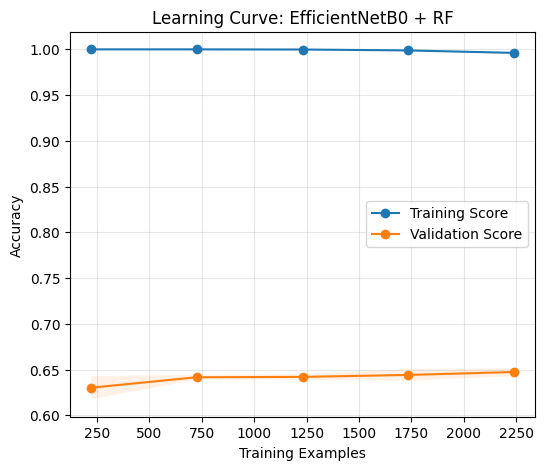


Plots generated: EfficientNetB0 + RF ❤️


In [ ]:
from sklearn.model_selection import learning_curve

# --------------------------------------------
# 3) LEARNING CURVE
# --------------------------------------------
def plot_learning(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        train_sizes=np.linspace(0.1,1.0,5),
        scoring="accuracy",
        n_jobs=-1
    )

    plt.figure(figsize=(6,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training Score")
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="Validation Score")

    plt.fill_between(train_sizes,
                     train_scores.mean(axis=1)-train_scores.std(axis=1),
                     train_scores.mean(axis=1)+train_scores.std(axis=1),
                     alpha=0.1)
    plt.fill_between(train_sizes,
                     val_scores.mean(axis=1)-val_scores.std(axis=1),
                     val_scores.mean(axis=1)+val_scores.std(axis=1),
                     alpha=0.1)

    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_learning(best_eff_rf, X_tr_eff, y_train_filtered, "Learning Curve: EfficientNetB0 + RF")

print("\nPlots generated: EfficientNetB0 + RF ❤️")

CLIP embeddings concat + MLP

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_proc = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def clip_encode_batch(df_data, batch=32):
    t_embs, i_embs = [], []
    processed_labels = []

    for i in tqdm(range(0, len(df_data), batch)):
        batch_df = df_data.iloc[i : i+batch]
        batch_texts = batch_df['clean_text'].astype(str).tolist()
        batch_imgs_paths = batch_df['img'].tolist()
        batch_labels = batch_df['label'].tolist()

        valid_texts = []
        valid_imgs = []
        current_batch_valid_labels = []

        for j, img_path in enumerate(batch_imgs_paths):
            try:
                img = Image.open(img_path).convert("RGB")
                valid_imgs.append(img)
                valid_texts.append(batch_texts[j])
                current_batch_valid_labels.append(batch_labels[j])
            except (Image.UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Skipping corrupted or missing image for CLIP: {img_path} ({e})")

        if not valid_imgs: # Skip batch if no valid images found
            continue

        inputs = clip_proc(text=valid_texts, images=valid_imgs, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            t = clip_model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
            im = clip_model.get_image_features(pixel_values=inputs['pixel_values'])

        t_embs.append(t.cpu().numpy())
        i_embs.append(im.cpu().numpy())
        processed_labels.extend(current_batch_valid_labels)

    return np.vstack(t_embs), np.vstack(i_embs), np.array(processed_labels)

train_t_clip, train_i_clip, y_train_clip_filtered = clip_encode_batch(df_train)
test_t_clip,  test_i_clip,  y_test_clip_filtered  = clip_encode_batch(df_test)

X_train_clip = np.hstack([train_t_clip, train_i_clip])
X_test_clip  = np.hstack([test_t_clip, test_i_clip])

 78%|███████▊  | 69/88 [08:53<02:24,  7.61s/it]

Skipping corrupted or missing image for CLIP: /content/drive/My Drive/hateful_memes_downsampled/processed_images/19543.png (cannot identify image file '/content/drive/My Drive/hateful_memes_downsampled/processed_images/19543.png')


100%|██████████| 19/19 [02:20<00:00,  7.38s/it]


In [ ]:
# MLP tuning
rs_mlp = RandomizedSearchCV(MLPClassifier(max_iter=300, random_state=42), {'hidden_layer_sizes':[(256,128),(512,256)], 'alpha':[1e-4,1e-3]}, n_iter=4, cv=3, n_jobs=-1, verbose=1)
rs_mlp.fit(X_train_clip, y_train_clip_filtered)
best_mlp = rs_mlp.best_estimator_
pred_clip = best_mlp.predict(X_test_clip)
print("CLIP+MLP acc:", accuracy_score(y_test_clip_filtered,pred_clip))
pickle.dump(best_mlp, open("member4_clip_mlp.pkl","wb"))

print("Loss eq for report: Binary cross-entropy: L = -[y log p + (1-y) log(1-p)]")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CLIP+MLP acc: 0.6883333333333334
Loss eq for report: Binary cross-entropy: L = -[y log p + (1-y) log(1-p)]


In [ ]:
# =====================================================
#   PLOTS FOR CLIP + MLP ONLY
# =====================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve
import numpy as np

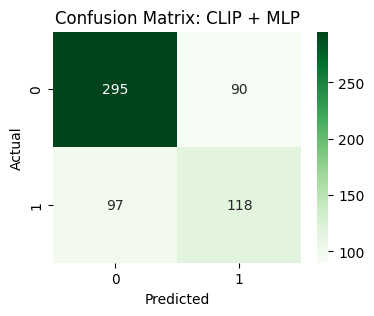

In [ ]:
# Assumes you already have:
# pred_clip , probs_clip , y_test , best_mlp , X_train_clip , y_train

# --------------------------------------------
# 1) CONFUSION MATRIX
# --------------------------------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, pred, "Confusion Matrix: CLIP + MLP")


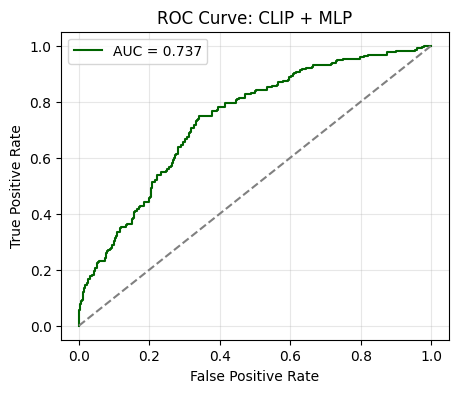

In [ ]:
# --------------------------------------------
# 2) ROC CURVE
# --------------------------------------------
def plot_roc(y_true, probs, title):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkgreen')
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_roc(y_test, probs_clip, "ROC Curve: CLIP + MLP")

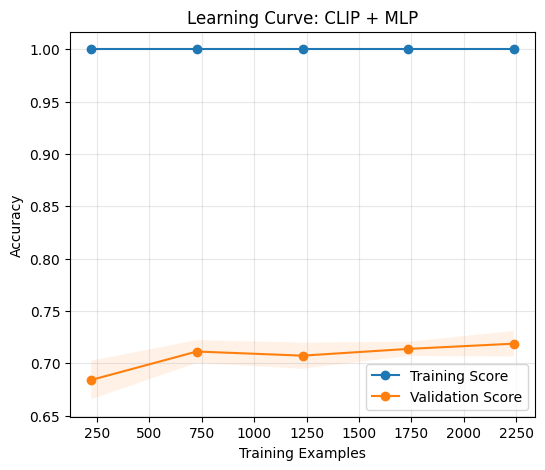


Plots generated: CLIP + MLP ❤️


In [ ]:
# --------------------------------------------
# 3) LEARNING CURVE
# --------------------------------------------
def plot_learning(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        train_sizes=np.linspace(0.1,1.0,5),
        scoring="accuracy",
        n_jobs=-1
    )

    plt.figure(figsize=(6,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training Score")
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="Validation Score")

    plt.fill_between(train_sizes,
                     train_scores.mean(axis=1)-train_scores.std(axis=1),
                     train_scores.mean(axis=1)+train_scores.std(axis=1),
                     alpha=0.1)
    plt.fill_between(train_sizes,
                     val_scores.mean(axis=1)-val_scores.std(axis=1),
                     val_scores.mean(axis=1)+val_scores.std(axis=1),
                     alpha=0.1)

    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_learning(best_mlp, X_train_clip, y_train_clip_filtered, "Learning Curve: CLIP + MLP")

print("\nPlots generated: CLIP + MLP ❤️")

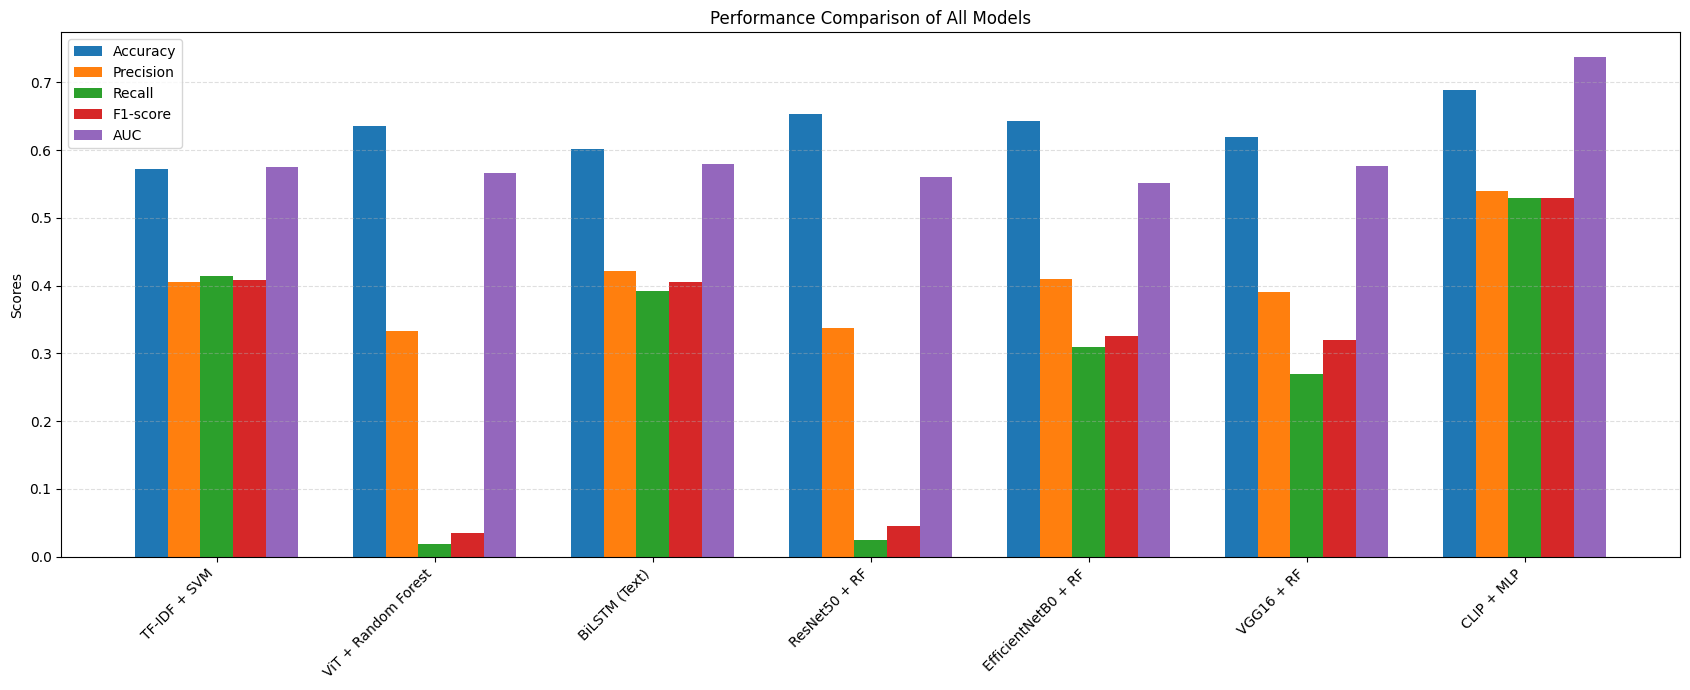

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ================================
# Performance table values (UPDATED)
# ================================

models = [
    "TF-IDF + SVM",
    "ViT + Random Forest",
    "BiLSTM (Text)",
    "ResNet50 + RF",
    "EfficientNetB0 + RF",
    "VGG16 + RF",
    "CLIP + MLP"
]

accuracy =  [0.572, 0.635, 0.602, 0.654, 0.6433, 0.62, 0.6883]
precision = [0.405, 0.333, 0.421, 0.338, 0.41, 0.39, 0.54]
recall =    [0.414, 0.019, 0.392, 0.025, 0.31, 0.27, 0.53]
f1_score =  [0.409, 0.035, 0.406, 0.046, 0.325, 0.32, 0.53]
auc =       [0.575, 0.566, 0.58, 0.56, 0.552, 0.5765, 0.737]

# ================================
# Bar graph (Grouped Bars)
# ================================

x = np.arange(len(models))
width = 0.15

plt.figure(figsize=(17, 7))

plt.bar(x - 2*width, accuracy,  width, label='Accuracy')
plt.bar(x - width,  precision, width, label='Precision')
plt.bar(x,          recall,    width, label='Recall')
plt.bar(x + width,  f1_score,  width, label='F1-score')
plt.bar(x + 2*width, auc,      width, label='AUC')

plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel("Scores")
plt.title("Performance Comparison of All Models")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [ ]:
!pip install -q transformers timm sentence-transformers captum matplotlib


In [ ]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from torchvision import models
from transformers import BertTokenizerFast, BertForSequenceClassification
import cv2
from captum.attr import LayerGradCam, LayerAttribution, IntegratedGradients
import math
import textwrap


ImportError: cannot import name 'is_torch_tpu_available' from 'transformers.utils' (/usr/local/lib/python3.12/dist-packages/transformers/utils/__init__.py)

In [ ]:
# Calculate pred_clip and probs_clip
pred_clip = best_mlp.predict(X_test_clip)
probs_clip = best_mlp.predict_proba(X_test_clip)[:, 1]

# Call plotting functions with the correctly defined variables
plot_confusion_matrix(y_test_clip_filtered, pred_clip, "Confusion Matrix: CLIP + MLP")
plot_roc(y_test_clip_filtered, probs_clip, "ROC Curve: CLIP + MLP")
plot_learning(best_mlp, X_train_clip, y_train_clip_filtered, "Learning Curve: CLIP + MLP")

NameError: name 'best_mlp' is not defined